In [1]:
import sklearn.datasets
import sklearn.metrics
import sklearn.model_selection

# From OpenML: https://www.openml.org/search?type=data&status=active&id=43672
dataset_name = "Heart-Disease-Dataset-(Comprehensive)"


def get_data_and_scoring_function(dataset_name):
    X, y = sklearn.datasets.fetch_openml(
        dataset_name, as_frame=True, return_X_y=True)
    X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(
        X,
        y,
        random_state=0,
        stratify=y,
    )

    def scoring_function(estimator):
        predictions = estimator.predict_proba(X_test)[:, 1]
        return sklearn.metrics.roc_auc_score(y_test, predictions)

    def train_scoring_function(estimator):
        predictions = estimator.predict_proba(X_train)[:, 1]
        return sklearn.metrics.roc_auc_score(y_train, predictions)

    def get_test_data():
        return X_test, y_test

    return (
        X,
        y,
        X_train,
        y_train,
        get_test_data,
        scoring_function,
        train_scoring_function,
    )


X, y, X_train, y_train, get_test_data, scoring_function, train_scoring_function = (
    get_data_and_scoring_function(dataset_name)
)

X_test, y_test = get_test_data()

print(f"Done Processing and downloading {dataset_name}")

/home/skhani/anaconda3/envs/SMAC2/lib/python3.10/site-packages/sklearn/datasets/_openml.py:322: UserWarning: Multiple active versions of the dataset matching the name heart-disease-dataset-(comprehensive) exist. Versions may be fundamentally different, returning version 1. Available versions:
- version 1, status: active
  url: https://www.openml.org/search?type=data&id=43672
- version 2, status: active
  url: https://www.openml.org/search?type=data&id=43682

  warn(warning_msg)


Done Processing and downloading Heart-Disease-Dataset-(Comprehensive)


In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report

# continuous and categorical features
continuous_features = [
    "age",
    "resting_bp_s",
    "cholesterol",
    "max_heart_rate",
    "oldpeak",
]
categorical_features = [
    "sex",
    "chest_pain_type",
    "fasting_blood_sugar",
    "resting_ecg",
    "exercise_angina",
    "ST_slope",
]

# Preprocessing for continuous features: Standardization
# Preprocessing for categorical features: One-Hot Encoding
preprocessor = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), continuous_features),
        ("cat", OneHotEncoder(), categorical_features),
    ]
)

pipeline = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        ("classifier", RandomForestClassifier(random_state=42)),
    ]
)

# Splitting data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [3]:
# cost from neg_log_loss
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import log_loss, make_scorer
import numpy as np
import numpy as np
from ConfigSpace import Categorical, Configuration, ConfigurationSpace, Float, Integer
from ConfigSpace.conditions import EqualsCondition
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import log_loss, make_scorer
from sklearn.model_selection import cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate, KFold
from sklearn.metrics import log_loss, make_scorer
import numpy as np


class RandomForestPipeline:

    def __init__(self, seed: int = 0):
        self.seed = seed

    @property
    def configspace(self) -> ConfigurationSpace:
        """
        Configuration Space to optimizer over. In particular, optimize over
        the hyperparameters of Random Forest.
        """
        cs = ConfigurationSpace(seed=self.seed)

        # Hyperparameters
        n_estimators = Integer("n_estimators", (10, 10000), default=100)
        criterion = Categorical(
            "criterion", ["gini", "entropy", "log_loss"], default="gini"
        )
        max_depth = Integer("max_depth", (1, 1000), default=None)
        min_samples_split = Float("min_samples_split", (0.0, 1))
        min_samples_leaf = Integer("min_samples_leaf", (1, 10), default=1)
        min_weight_fraction_leaf = Float(
            "min_weight_fraction_leaf", (0.0, 0.1), default=0.0
        )
        max_features = Float("max_features", (0.0, 1))
        max_leaf_nodes = Integer("max_leaf_nodes", (10, 1000), default=None)
        min_impurity_decrease = Float("min_impurity_decrease", (0.0, 0.02), default=0.0)
        bootstrap = Categorical("bootstrap", [True, False], default=True)
        oob_score = Categorical("oob_score", [True, False], default=False)
        warm_start = Categorical("warm_start", [True, False], default=False)
        class_weight = Categorical(
            "class_weight", ["balanced", "balanced_subsample"], default=None
        )
        ccp_alpha = Float("ccp_alpha", (0.0, 0.001), default=0.0)
        max_samples = Float("max_samples", (0.0, 1.0), default=None)

        cs.add_hyperparameters(
            [
                n_estimators,
                criterion,
                max_depth,
                min_samples_split,
                min_samples_leaf,
                min_weight_fraction_leaf,
                max_features,
                max_leaf_nodes,
                min_impurity_decrease,
                bootstrap,
                oob_score,
                warm_start,
                class_weight,
                ccp_alpha,
                max_samples,
            ]
        )

        # Conditions
        # OOB score only makes sense if bootstrap is True
        oob_score_condition = EqualsCondition(
            child=cs["oob_score"], parent=cs["bootstrap"], value=True
        )
        # "balanced" or "balanced_subsample" class weights is not recommended when warm_start=True
        class_weight_condition = EqualsCondition(
            child=cs["class_weight"], parent=cs["warm_start"], value=False
        )
        # max_features_condition = EqualsCondition(
        #     child=cs["max_features"], parent=cs["criterion"], value="entropy"
        # )
        # Creating the EqualsCondition to link `max_samples` activation with `bootstrap` being True
        max_sample_condition = EqualsCondition(
            child=cs["max_samples"], parent=cs["bootstrap"], value=True
        )

        cs.add_condition(oob_score_condition)
        cs.add_condition(class_weight_condition)
        cs.add_condition(max_sample_condition)

        return cs

    def train(self, config: Configuration, seed: int = 0) -> float:
        """
        Creates a RandomForestClassifier based on a configuration and evaluates it
        on a dataset using cross-validation, with the evaluation metric being the negative log loss.
        """
        config_dict = dict(config)

        np.random.seed(seed=seed)
        
        # Create a RandomForestClassifier with the specified hyperparameters
        clf = RandomForestClassifier(
            n_jobs=-1,
            # max_samples=budget,
            random_state=seed,
            **config_dict  
        )

        # Evaluate the classifier using cross-validation with negative log loss
        scores = cross_val_score(
            clf,
            X_train,
            y_train,
            cv=5,
            scoring="neg_log_loss",
        )

        # Return the mean of the negative log loss scores
        return -np.mean(scores)

In [4]:
import time
from smac.multi_objective.parego import ParEGO


class RFWithTime(RandomForestPipeline):
    def train(self, config: Configuration, seed: int = 0) -> dict[str, float]:
        start_time = time.time()
        cost = super(RFWithTime, self).train(config, seed)
        return {
            "cost": cost,
            "time": time.time() - start_time,
        }

In [5]:
from smac import HyperparameterOptimizationFacade, Scenario

# Your RandomForestPipeline instance
# rf = RandomForestPipeline()

RF_time = RFWithTime()
objectives = ["cost", "time"]

seeds = [0]
# seeds = [0, 100, 200, 300, 400, 500, 600, 700, 800, 900]

for seed in seeds:  # Iterate over specified seeds
    scenario = Scenario(
        RF_time.configspace,  
        name="Multi-Objective",
        n_trials=1000,
        objectives=objectives,
        deterministic=True,
        walltime_limit=5 * 60,
        seed=seed,
        n_workers=15,
    )
    multi_objective_algorithm = ParEGO(scenario)
    # Create our SMAC object and pass the scenario and the train method
    smac = HyperparameterOptimizationFacade(
        scenario,
        RF_time.train,
        # initial_design=initial_design,
        multi_objective_algorithm=multi_objective_algorithm,
        # intensifier=intensifier,
        overwrite=True,
    )

    # Let's optimize
    incumbents = smac.optimize()

    # Get cost of default configuration
    default_cost = smac.validate(
        RF_time.configspace.get_default_configuration())
    print(f"Validated costs from default config: \n--- {default_cost}\n")

    print("Validated costs from the Pareto front (incumbents):")
    for incumbent in incumbents:
        cost = smac.validate(incumbent)
        print("---", cost)

[INFO][abstract_initial_design.py:147] Using 150 initial design configurations and 0 additional configurations.
[INFO][abstract_intensifier.py:305] Using only one seed for deterministic scenario.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][smbo.py:319] Finished 0 trials.
[INFO][abstract_intensifier.py:515] Added config f50aea as new incumbent because there are no incumbents yet.
[INFO][abstract_intensifier.py:598] Config 02e9c1 is a new incumbent. Total number of incumbents: 2.
[INFO][a

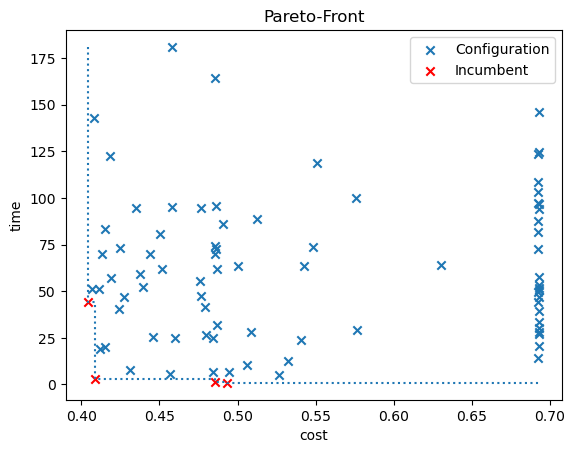

In [6]:
from matplotlib import pyplot as plt

# Now we can plot the pareto front found by smac


def plot_pareto(
    smac: HyperparameterOptimizationFacade, incumbents: list[Configuration]
) -> None:
    """Plots configurations from SMAC and highlights the best configurations in a Pareto front."""
    average_costs = []
    average_pareto_costs = []
    for config in smac.runhistory.get_configs():
        # Since we use multiple seeds, we have to average them to get only one cost value pair for each configuration
        average_cost = smac.runhistory.average_cost(config)

        if config in incumbents:
            average_pareto_costs += [average_cost]
        else:
            average_costs += [average_cost]

    # Let's work with a numpy array
    costs = np.vstack(average_costs)
    pareto_costs = np.vstack(average_pareto_costs)
    pareto_costs = pareto_costs[pareto_costs[:, 0].argsort()]  # Sort them

    costs_x, costs_y = costs[:, 0], costs[:, 1]
    pareto_costs_x, pareto_costs_y = pareto_costs[:, 0], pareto_costs[:, 1]

    plt.scatter(costs_x, costs_y, marker="x", label="Configuration")
    plt.scatter(pareto_costs_x, pareto_costs_y, marker="x", c="r", label="Incumbent")
    plt.step(
        [pareto_costs_x[0]]
        + pareto_costs_x.tolist()
        + [np.max(costs_x)],  # We add bounds
        [np.max(costs_y)]
        + pareto_costs_y.tolist()
        + [np.min(pareto_costs_y)],  # We add bounds
        where="post",
        linestyle=":",
    )

    plt.title("Pareto-Front")
    plt.xlabel(smac.scenario.objectives[0])
    plt.ylabel(smac.scenario.objectives[1])
    plt.legend()
    plt.show()


# Let's plot a pareto front
plot_pareto(smac, incumbents)